In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pump-fun-graduation-february-2025/chunk_40.csv
/kaggle/input/pump-fun-graduation-february-2025/chunk_23.csv
/kaggle/input/pump-fun-graduation-february-2025/chunk_18.csv
/kaggle/input/pump-fun-graduation-february-2025/chunk_21.csv
/kaggle/input/pump-fun-graduation-february-2025/chunk_38.csv
/kaggle/input/pump-fun-graduation-february-2025/chunk_37.csv
/kaggle/input/pump-fun-graduation-february-2025/chunk_36.csv
/kaggle/input/pump-fun-graduation-february-2025/chunk_14.csv
/kaggle/input/pump-fun-graduation-february-2025/chunk_6.csv
/kaggle/input/pump-fun-graduation-february-2025/chunk_35.csv
/kaggle/input/pump-fun-graduation-february-2025/chunk_34.csv
/kaggle/input/pump-fun-graduation-february-2025/chunk_32.csv
/kaggle/input/pump-fun-graduation-february-2025/token_info_onchain_divers.csv
/kaggle/input/pump-fun-graduation-february-2025/chunk_17.csv
/kaggle/input/pump-fun-graduation-february-2025/test_unlabeled.csv
/kaggle/input/pump-fun-graduation-february-2025/chunk_8.csv
/ka

In [2]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import glob

here we have load the dataset and combined all the chunk values 

In [3]:
# Load the base datasets
df_dune1 = pd.read_csv('/kaggle/input/pump-fun-graduation-february-2025/dune_token_info.csv')
df_dune2 = pd.read_csv('/kaggle/input/pump-fun-graduation-february-2025/dune_token_info_v2.csv')
df_onchain1 = pd.read_csv('/kaggle/input/pump-fun-graduation-february-2025/token_info_onchain_divers.csv')
df_onchain2 = pd.read_csv('/kaggle/input/pump-fun-graduation-february-2025/token_info_onchain_divers_v2.csv')

# Training & test datasets
df_train = pd.read_csv("/kaggle/input/pump-fun-graduation-february-2025/train.csv")
df_test = pd.read_csv("/kaggle/input/pump-fun-graduation-february-2025/test_unlabeled.csv")


# Load chunk files
chunks_path = '/kaggle/input/pump-fun-graduation-february-2025/'
chunk_files = glob.glob(chunks_path + 'chunk_*.csv') 
print(f"Found {len(chunk_files)} chunk files.")

# Combine all chunk files into a single DataFrame
list_of_chunks = []
for file in chunk_files:
    df_chunk = pd.read_csv(file)
    list_of_chunks.append(df_chunk)

df_chunks_all = pd.concat(list_of_chunks, ignore_index=True)
print("Shape of combined chunk data:", df_chunks_all.shape)


/tmp/ipykernel_31/2262831020.py:4: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_onchain1 = pd.read_csv('/kaggle/input/pump-fun-graduation-february-2025/token_info_onchain_divers.csv')


Found 41 chunk files.
Shape of combined chunk data: (17033442, 15)


here we have combined the matadata which was optional used if needed 

In [4]:
metadata = pd.concat([df_dune1, df_dune2, df_onchain1, df_onchain2])

In labels we have saved the target values so that we can used it in future for model training 

In [5]:
labels = df_train[['mint' , 'slot_graduated', 'has_graduated']].copy()

Now here we will merge the train and test based on the is_test feature and so it can easy to do the feature engineering 

In [6]:
df_train["is_test"] = False 
df_test["is_test"] = True 


In [7]:
df_train_clean = df_train.drop(columns=['slot_graduated','has_graduated']) 

df_all = pd.concat([df_train_clean ,df_test], ignore_index=True)  

print(df_all.shape)

(1118389, 5)


In [8]:
token_mints = set(df_all['mint'].unique()) 
df_chunks_filtered = df_chunks_all[df_chunks_all['base_coin'].isin(token_mints)]

Here we have performed the feautre engineering to make the data more better 

In [9]:
# Let's group by base_coin (= token mint)

features = df_chunks_filtered.groupby('base_coin').agg(
    n_transactions = ('tx_idx', 'count'),            # How many transactions
    n_buys = ('direction', lambda x: (x == 'buy').sum()),   # How many buys
    n_sells = ('direction', lambda x: (x == 'sell').sum()), # How many sells
    total_base_volume = ('base_coin_amount', 'sum'),   # Total tokens traded
    total_quote_volume = ('quote_coin_amount', 'sum'), # Total SOL involved
    avg_base_amount = ('base_coin_amount', 'mean'),    # Avg token amount per tx
    avg_quote_amount = ('quote_coin_amount', 'mean'),  # Avg SOL per tx
)

# Reset index
features = features.reset_index()

features.rename(columns={'base_coin': 'mint'}, inplace=True)


In [10]:
df_all = df_all.merge(features, on='mint', how='left') 

In [11]:
features['buy_sell_imbalance'] = (features['n_buys'] - features['n_sells']) / (features['n_buys'] + features['n_sells'] + 1e-5)


In [12]:
# Group buys
buyers = df_chunks_filtered[df_chunks_filtered['direction'] == 'buy'].groupby('base_coin')['signing_wallet'].nunique().reset_index()
buyers.rename(columns={'signing_wallet': 'n_unique_buyers', 'base_coin': 'mint'}, inplace=True)

# Group sells
sellers = df_chunks_filtered[df_chunks_filtered['direction'] == 'sell'].groupby('base_coin')['signing_wallet'].nunique().reset_index()
sellers.rename(columns={'signing_wallet': 'n_unique_sellers', 'base_coin': 'mint'}, inplace=True)

# Merge back into df_all
df_all = df_all.merge(buyers, on='mint', how='left')
df_all = df_all.merge(sellers, on='mint', how='left')

In [13]:
# Step 1: Group by 'base_coin'
max_buy_volume = df_chunks_filtered[df_chunks_filtered['direction'] == 'buy'].groupby('base_coin')['quote_coin_amount'].max().reset_index()

# Step 2: Rename 'base_coin' to 'mint' before merging
max_buy_volume.rename(columns={'quote_coin_amount': 'max_single_buy', 'base_coin': 'mint'}, inplace=True)

# Step 3: Merge
df_all = df_all.merge(max_buy_volume, on='mint', how='left')

In [14]:
# Let's compute avg time difference between transactions (using 'slot' instead of 'block')

time_diff = df_chunks_filtered.groupby('base_coin').agg(
    slot_min=('slot', 'min'),
    slot_max=('slot', 'max'),
    n_tx=('tx_idx', 'count')
).reset_index()

# Calculate slot difference
time_diff['slot_diff'] = time_diff['slot_max'] - time_diff['slot_min']

# Average number of slots between each transaction
time_diff['avg_slots_per_tx'] = time_diff['slot_diff'] / (time_diff['n_tx'] + 1e-5)

# Rename 'base_coin' to 'mint' so it can merge properly
time_diff.rename(columns={'base_coin': 'mint'}, inplace=True)

# Merge with df_all
df_all = df_all.merge(time_diff[['mint', 'avg_slots_per_tx']], on='mint', how='left')
df_all.head(10)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Unnamed: 0,mint,slot_min,is_valid,is_test,n_transactions,n_buys,n_sells,total_base_volume,total_quote_volume,avg_base_amount,avg_quote_amount,n_unique_buyers,n_unique_sellers,max_single_buy,avg_slots_per_tx
0,1,BmTDA5HqcemLkEgpyK25sDhbvk652CTXjdWEa8fLpump,317876496,True,False,3,2,1,176726650812150,5656628945,5.890888e+13,1.885543e+09,2.0,1.0,3.644123e+09,17.666608
1,3,4FJwryCAMMePNeWw9LTBXXfXABdkKcAxkTT6h9pdpump,317876500,True,False,1,1,0,67062499999999,2000000000,6.706250e+13,2.000000e+09,1.0,NaN,2.000000e+09,0.000000
2,4,DeXchZLMzFm9nfvkfTKiXvBWWEpGMF6VDzvbMB6mpump,317876500,True,False,3,2,1,86061539990406,2574964315,2.868718e+13,8.583214e+08,2.0,1.0,1.000000e+09,3.999987
3,5,6Mx4fnEPWpRLKtxY8VzVXo3CWwu2dvGp9BSJMWfVpump,317876500,True,False,1,1,0,126235294117647,4000000000,1.262353e+14,4.000000e+09,1.0,NaN,4.000000e+09,0.000000
4,6,4rbGH5peYV3FvCfncfsfwtBNwpjiG36nZtvxoPZ9pump,317876500,True,False,13,8,5,242769112649282,7874963043,1.867455e+13,6.057664e+08,8.0,5.0,1.200000e+09,7.230764
5,8,4xckRo8CXFWm9RCUWE1XjickFzXPngfySdmZ8reEpump,317876501,True,False,10,8,2,90347723472976,2627907555,9.034772e+12,2.627908e+08,8.0,2.0,1.000000e+09,6.599993
6,11,3ZRr93pUGJK8t6jKjeGbFWBBpB5MPAf6tXPiVs4VBicP,317876504,True,False,15,10,5,625934662546727,24066022997,4.172898e+13,1.604402e+09,9.0,5.0,5.200000e+09,4.066664
7,13,8H5XL3kKvCkv2zdnR7zuvHakPFRZTpYM3V1B7EqDpump,317876506,True,False,3,2,1,86061539990406,2574964315,2.868718e+13,8.583214e+08,2.0,1.0,1.000000e+09,3.999987
8,14,3rhbGqWsYnCqSnnJckGoD6jdsEnx6LmkWWdQ41yUyY1V,317876506,True,False,2,2,0,733037963213,20509015,3.665190e+11,1.025451e+07,2.0,NaN,2.048902e+07,2.499988
9,16,75kWpm7MFAKkXqDGro1fVDLyjeygeyaxw67Gov8epump,317876508,True,False,21,21,0,793100000000000,85005359057,3.776667e+13,4.047874e+09,21.0,NaN,1.100000e+10,0.000000


In [15]:
# Fill NaN with 0
df_all.fillna(0, inplace=True)

# Ensure 'is_valid' is an integer
df_all['is_valid'] = df_all['is_valid'].astype(int)

# Step 1: Split into train and test
df_train = df_all[df_all['is_test'] == False].copy()
df_test = df_all[df_all['is_test'] == True].copy()

# Merge labels into df_train
df_train = df_train.merge(labels, on='mint', how='left')

# --- NEW FIX: Handling object type mint values ---

# Combine train and test 'mint' values for encoding
combined_mints = pd.concat([df_train['mint'], df_test['mint']], axis=0)

# Apply LabelEncoder to the combined 'mint' column
label_encoder = LabelEncoder()
label_encoder.fit(combined_mints)

# Transform 'mint' in train and test
df_train['mint'] = label_encoder.transform(df_train['mint'])
df_test['mint'] = label_encoder.transform(df_test['mint'])

# Check if everything looks fine
df_train.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Unnamed: 0,mint,slot_min,is_valid,is_test,n_transactions,n_buys,n_sells,total_base_volume,total_quote_volume,avg_base_amount,avg_quote_amount,n_unique_buyers,n_unique_sellers,max_single_buy,avg_slots_per_tx,slot_graduated,has_graduated
0,1,632193,317876496,1,False,3,2,1,176726650812150,5656628945,5.890888e+13,1.885543e+09,2.0,1.0,3.644123e+09,17.666608,NaN,False
1,3,146356,317876500,1,False,1,1,0,67062499999999,2000000000,6.706250e+13,2.000000e+09,1.0,0.0,2.000000e+09,0.000000,NaN,False
2,4,754120,317876500,1,False,3,2,1,86061539990406,2574964315,2.868718e+13,8.583214e+08,2.0,1.0,1.000000e+09,3.999987,NaN,False
3,5,281705,317876500,1,False,1,1,0,126235294117647,4000000000,1.262353e+14,4.000000e+09,1.0,0.0,4.000000e+09,0.000000,NaN,False
4,6,184902,317876500,1,False,13,8,5,242769112649282,7874963043,1.867455e+13,6.057664e+08,8.0,5.0,1.200000e+09,7.230764,NaN,False


In [16]:
# Convert 'has_graduated' from True/False to 1/0
df_train['has_graduated'] = df_train['has_graduated'].map({True: 1, False: 0})

# Convert NaN values in 'slot_graduated' to 0
df_train['slot_graduated'] = df_train['slot_graduated'].fillna(0)

# Convert 'is_test' to numeric (1 for True, 0 for False) or drop it based on your decision
# If 'is_test' is important, convert it to numeric
df_train['is_test'] = df_train['is_test'].map({True: 1, False: 0})

# Alternatively, if 'is_test' is not important anymore (since you've split data already), you can drop it
# df.drop(columns=['is_test'], inplace=True)

# Check the result
df_train.head()


,Unnamed: 0,mint,slot_min,is_valid,is_test,n_transactions,n_buys,n_sells,total_base_volume,total_quote_volume,avg_base_amount,avg_quote_amount,n_unique_buyers,n_unique_sellers,max_single_buy,avg_slots_per_tx,slot_graduated,has_graduated
0,1,632193,317876496,1,0,3,2,1,176726650812150,5656628945,5.890888e+13,1.885543e+09,2.0,1.0,3.644123e+09,17.666608,0.0,0
1,3,146356,317876500,1,0,1,1,0,67062499999999,2000000000,6.706250e+13,2.000000e+09,1.0,0.0,2.000000e+09,0.000000,0.0,0
2,4,754120,317876500,1,0,3,2,1,86061539990406,2574964315,2.868718e+13,8.583214e+08,2.0,1.0,1.000000e+09,3.999987,0.0,0
3,5,281705,317876500,1,0,1,1,0,126235294117647,4000000000,1.262353e+14,4.000000e+09,1.0,0.0,4.000000e+09,0.000000,0.0,0
4,6,184902,317876500,1,0,13,8,5,242769112649282,7874963043,1.867455e+13,6.057664e+08,8.0,5.0,1.200000e+09,7.230764,0.0,0


This were the values we have build during the feature engineering but after analysis we understand that they dont play much importance so we can discard them 

In [17]:
to_drop = [
  'Unnamed: 0', 'is_test', 'is_valid', 'slot_min',
  'avg_base_amount', 'avg_quote_amount'
]
df_train.drop(columns=to_drop, inplace=True)
df_test .drop(columns=to_drop, inplace=True)   

In [18]:
df_train.head()

,mint,n_transactions,n_buys,n_sells,total_base_volume,total_quote_volume,n_unique_buyers,n_unique_sellers,max_single_buy,avg_slots_per_tx,slot_graduated,has_graduated
0,632193,3,2,1,176726650812150,5656628945,2.0,1.0,3.644123e+09,17.666608,0.0,0
1,146356,1,1,0,67062499999999,2000000000,1.0,0.0,2.000000e+09,0.000000,0.0,0
2,754120,3,2,1,86061539990406,2574964315,2.0,1.0,1.000000e+09,3.999987,0.0,0
3,281705,1,1,0,126235294117647,4000000000,1.0,0.0,4.000000e+09,0.000000,0.0,0
4,184902,13,8,5,242769112649282,7874963043,8.0,5.0,1.200000e+09,7.230764,0.0,0


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

we have used this graph to understand the correlation between the feature and target values we also have perfrom various graph to understand the data 

<Axes: >

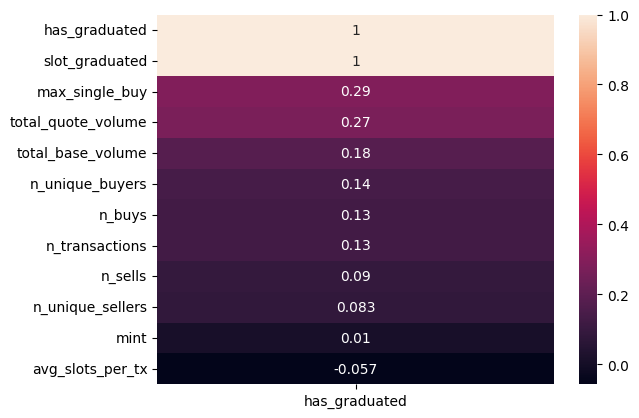

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check correlations
corr_matrix = df_train.corr()
sns.heatmap(corr_matrix[['has_graduated']].sort_values(by='has_graduated', ascending=False), annot=True)


In [21]:
df_clean = df_train.drop(columns=['slot_graduated'])

In [22]:
# Features and target
X = df_clean.drop(columns=['has_graduated'])
y = df_clean['has_graduated']

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_val)
rf_pred_proba = rf.predict_proba(X_val)[:, 1]


In [ ]:
# XGBoost
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_val)
xgb_pred_proba = xgb.predict_proba(X_val)[:, 1]

In [ ]:
# ------------------ Evaluation ------------------

rf_acc = accuracy_score(y_val, rf_preds)
xgb_acc = accuracy_score(y_val, xgb_preds)

rf_loss = log_loss(y_val, rf_pred_proba)
xgb_loss = log_loss(y_val, xgb_pred_proba)

print(f"Random Forest Accuracy: {rf_acc:.4f}, Log Loss: {rf_loss:.4f}")
print(f"XGBoost Accuracy: {xgb_acc:.4f}, Log Loss: {xgb_loss:.4f}")

In [ ]:
# Accuracy & Log Loss comparison
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Accuracy plot
axs[0].bar(['Random Forest', 'XGBoost'], [rf_acc, xgb_acc], color=['skyblue', 'lightgreen'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylim(0, 1.05)
axs[0].set_ylabel('Accuracy')
# Log loss plot
axs[1].bar(['Random Forest', 'XGBoost'], [rf_loss, xgb_loss], color=['salmon', 'orange'])
axs[1].set_title('Model Log Loss')
axs[1].set_ylabel('Log Loss')

plt.tight_layout()
plt.show()


In [ ]:
# Show error vs actuals
plt.figure(figsize=(10, 5))
plt.plot(y_val.reset_index(drop=True), label='Actual', alpha=0.7)
plt.plot(rf_pred_proba, label='Random Forest Predicted Prob.', linestyle='--')
plt.plot(xgb_pred_proba, label='XGBoost Predicted Prob.', linestyle='--')
plt.title("Prediction vs Actual (Probabilities)")
plt.xlabel("Sample Index")
plt.ylabel("Probability of 'has_graduated'")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Drop unnecessary columns if they exist
df_test = df_test.drop(columns=['graduated_prob', 'predicted_class'], errors='ignore')

# Extract only the features used during training (excluding 'mint')
X_test = df_test

# Predict probabilities using the trained RandomForest model
rf_pred_proba_test = rf.predict_proba(X_test)[:, 1]

# Flag high-probability graduates
df_test['graduated_prob'] = rf_pred_proba_test
df_test['predicted_class'] = (rf_pred_proba_test > 0.5).astype(int)  # using threshold = 0.5


In [ ]:
# View top 10 likely graduates
df_test.sort_values('graduated_prob', ascending=False).head(10)


In [ ]:
importances = rf.feature_importances_
features = X.columns

# Create a DataFrame for easy plotting
feat_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feat_importance_df['Feature'], feat_importance_df['Importance'], color='skyblue')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


In [ ]:
xgb_importance = xgb.feature_importances_

feat_importance_xgb_df = pd.DataFrame({'Feature': features, 'Importance': xgb_importance})
feat_importance_xgb_df = feat_importance_xgb_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_importance_xgb_df['Feature'], feat_importance_xgb_df['Importance'], color='lightgreen')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


In [ ]:
X_test = df_test.drop(columns=['graduated_prob', 'predicted_class'], errors='ignore')
rf_pred_proba_test = rf.predict_proba(X_test)[:, 1]

# Build the submission DataFrame in the required format
submission_df = pd.DataFrame({
    'mint': df_test['mint'].values,
    'has_graduated': rf_pred_proba_test
})


In [ ]:
train_cols = df_train.columns.tolist() 
print(train_cols)
test_cols = df_test.columns.tolist() 
print(test_cols) 

In [ ]:
df_test = df_test.drop(columns=['graduated_prob', 'predicted_class'], errors='ignore')

In [ ]:
sub_preds = xgb.predict_proba(df_test)[:, 1]  

In [ ]:
# Load sample submission to preserve 'mint' column and row order
sub_df = pd.read_csv('/kaggle/input/solana-skill-sprint-memcoin-graduation/sample_submission.csv')


In [ ]:
# Insert your model's predictions
sub_df['has_graduated'] = sub_preds 

In [ ]:
# Optional: check the range of predictions
print("Unique predicted probabilities (rounded):", np.unique(sub_df['has_graduated'].round(2))) 


so it suggest high confidence in the model that starting values have to less chance of getting more volume than required threshold 

In [ ]:
# Save to submission file
sub_df.to_csv('/kaggle/working/Aarya naik.csv', index=False)

# Preview first few rows
print(sub_df.head())